## VAD

In [10]:
# pip install rVADfast

import audiofile
from rVADfast import rVADfast

vad = rVADfast()
path_to_audiofile = "tmp/23-217818-23_2304031351_11395.opus"

waveform, sampling_rate = audiofile.read(path_to_audiofile)
vad_labels, vad_timestamps = vad(waveform.mean(0), sampling_rate) # 1m 23.7s

In [ ]:
from funasr import AutoModel

model = AutoModel(model="fsmn-vad")
res = model.generate(input=path_to_audiofile)
print(res)

In [ ]:
import IPython.display as ipd

wav = waveform.mean(0)

for value in res[0]['value']:
    start = int(value[0] / 16000 * sampling_rate)
    end = int(value[1] / 16000 * sampling_rate)
    ipd.display(ipd.Audio(wav[start:end], rate=sampling_rate))
    break

# Output audio is not correct, too short, not sure is it due to sampling rate

775.1575625
677.8395625


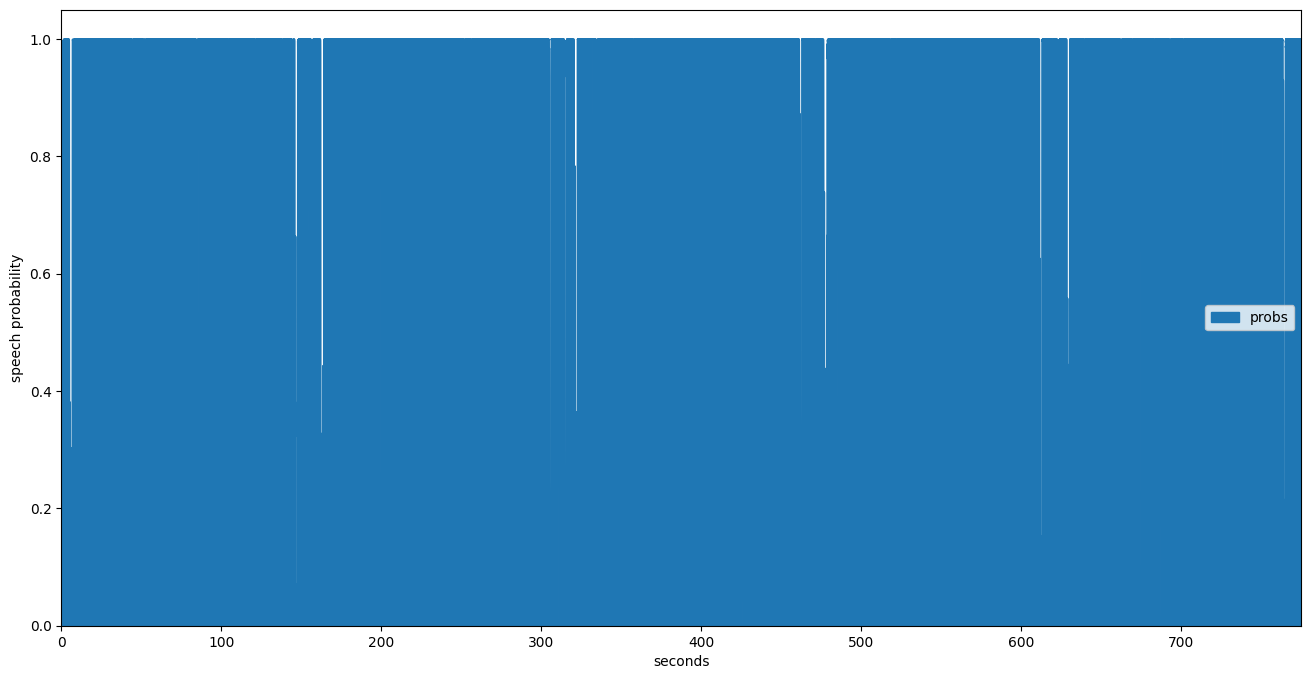

In [17]:
import torch
import soundfile as sf

max_duration = 30
min_duration = 2

# USE_ONNX = True  # change this to True if you want to test onnx model
# model, utils = torch.hub.load(
#     repo_or_dir="snakers4/silero-vad",
#     model="silero_vad",
#     force_reload=True,
#     onnx=USE_ONNX,
# )
# sampling_rate = 16000
# (get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks) = utils
# vad_iterator = VADIterator(model, sampling_rate=sampling_rate)
# wav = read_audio("tmp/23-217818-23_2304031351_11395_16k.mp3")
speech_timestamps = get_speech_timestamps(
    wav,
    model,
    sampling_rate=sampling_rate,
    # threshold=0.3,
    # max_speech_duration_s=max_duration,
    # min_speech_duration_ms=min_duration * sampling_rate,
    # min_silence_duration_ms=300,
    # speech_pad_ms=100,
    visualize_probs=True,
)

print(wav.shape[0] / sampling_rate)
print(sum([speech_timestamp["end"] - speech_timestamp["start"] for speech_timestamp in speech_timestamps]) / sampling_rate)

# for i, speech_timestamp in enumerate(speech_timestamps):
#     start = speech_timestamp["start"]
#     end = speech_timestamp["end"]
#     chunk_wav = wav[start:end]
#     sf.write("tmp/chunk_{}.wav".format(i), chunk_wav, sampling_rate)

In [ ]:
# !pip install pyannote.audio pyannote.metrics pyannote.pipeline pyannote.core pyannote.database pytorch_metric_learning asteroid_filterbanks torch_audiomentations optuna torch_pitch_shift primePy semver julius --no-deps

from pyannote.audio import Pipeline
import librosa
import torch

pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1")

path_to_audiofile = "tmp/23-217818-23_2304031351_11395.mp3"

# send pipeline to GPU (when available)
pipeline.to(torch.device("cuda"))

In [8]:
import IPython.display as ipd
import soundfile as sf


def vad(
    path_to_audiofile: str,
    sampling_rate=16_000,
    min_duration_before_turn_ms=600,
    min_duration_ms=1_000,
):
    waveform, _ = librosa.load(path_to_audiofile, sr=sampling_rate, mono=True)
    wav = torch.tensor(waveform).unsqueeze(0)
    min_duration_before_turn = min_duration_before_turn_ms / 1_000 * sampling_rate
    min_duration = min_duration_ms / 1_000 * sampling_rate

    # apply pretrained pipeline
    diarization = pipeline({"waveform": wav, "sample_rate": sampling_rate})
    last_speaker = None
    last_start = 0
    last_end = 0
    output_chunks = []

    for turn, _, speaker in diarization.itertracks(yield_label=True):
        start = int(turn.start * sampling_rate)
        end = int(turn.end * sampling_rate)

        if last_speaker == speaker and (start - last_end) < min_duration_before_turn:
            last_end = end
        else:
            if last_end != 0:
                output_chunks.append(waveform[last_start:last_end])
            last_start = start
            last_end = end
            last_speaker = speaker

    # Append the last chunk
    duration = last_end - last_start
    if last_end != 0 and duration > min_duration:
        output_chunks.append(waveform[last_start:last_end])

    return output_chunks


chunks = vad("tmp/23-217818-23_2304031351_11395.mp3")

for i, chunk in enumerate(chunks):
    # ipd.display(ipd.Audio(chunk, rate=16_000))
    sf.write(f"tmp/chunk_{i}.wav", chunk, 16_000)

In [11]:
from speechbrain.inference.VAD import VAD
import librosa
import soundfile as sf

VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="pretrained_models/vad-crdnn-libriparty")
boundaries = VAD.get_speech_segments("tmp/23-217818-23_2304031351_11395_16k.mp3", apply_energy_VAD=True)

wav, _ = librosa.load("tmp/23-217818-23_2304031351_11395_16k.mp3", sr=16000)

for i in range(len(boundaries)):
    start, end = boundaries[i]
    start = int(start.item() * 16000)
    end = int(end.item() * 16000)
    sf.write(f"tmp/chunk_{i}.wav", wav[start:end], 16_000)

/opt/conda/envs/bert-vits2/lib/python3.11/site-packages/speechbrain/utils/checkpoints.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(path, map_location=dev

In [ ]:
# check invalid mp3
import audioread
import os

root_folder = "audios"

audio_files = os.listdir(root_folder)
output_files = [
    os.path.join(root_folder, audio_file)
    for audio_file in audio_files
    if audio_file.endswith(".mp3")
]

for out_file in output_files:
    try:
        with audioread.audio_open(out_file) as f:
            print(f.channels, f.samplerate, f.duration)
    except Exception as e:
        print(out_file, e)

In [1]:
from diarizer import Diarizer
import torchaudio

wav, _ = torchaudio.load("tmp/23-217818-23_2304031351_11395_16k.mp3")
diar = Diarizer(
    embed_model="ecapa",  # supported types: ['xvec', 'ecapa']
    cluster_method="sc",  # supported types: ['ahc', 'sc']
    window=1.5,  # size of window to extract embeddings (in seconds)
    period=0.75,  # hop of window (in seconds)
)
segments = diar.diarize(wav)

segments

Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
/opt/conda/envs/bert-vits2/lib/python3.11/site-packages/speechbrain/utils/autocast.py:63: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
/opt/conda/envs/bert-vits2/lib/python3.11/site-packages/speechbrain/utils/checkpoints.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be

Running VAD...
Splitting by silence found 258 utterances
Extracting embeddings...


Utterances:   0%|          | 0/258 [00:00<?, ?it/s]

Clustering to None speakers...
Cleaning up output...
Done!


[{'start': 0.066,
  'end': 1.1499375,
  'label': 0,
  'start_sample': 1056,
  'end_sample': 18399},
 {'start': 1.474,
  'end': 2.9419375,
  'label': 0,
  'start_sample': 23584,
  'end_sample': 47071},
 {'start': 3.202,
  'end': 4.8619375,
  'label': 0,
  'start_sample': 51232,
  'end_sample': 77791},
 {'start': 7.01,
  'end': 12.1259375,
  'label': 0,
  'start_sample': 112160,
  'end_sample': 194015},
 {'start': 12.354,
  'end': 16.3179375,
  'label': 0,
  'start_sample': 197664,
  'end_sample': 261087},
 {'start': 16.866,
  'end': 18.4299375,
  'label': 0,
  'start_sample': 269856,
  'end_sample': 294879},
 {'start': 18.658,
  'end': 19.7739375,
  'label': 0,
  'start_sample': 298528,
  'end_sample': 316383},
 {'start': 20.066,
  'end': 33.1499375,
  'label': 0,
  'start_sample': 321056,
  'end_sample': 530399},
 {'start': 33.442,
  'end': 34.4299375,
  'label': 0,
  'start_sample': 535072,
  'end_sample': 550879},
 {'start': 34.658,
  'end': 37.2779375,
  'label': 0,
  'start_sample'

In [3]:
import soundfile as sf

for i, segment in enumerate(segments):
    start = int(segment['start'] * 16000)
    end = int(segment['end'] * 16000)
    chunk = wav[0, start:end]
    
    sf.write("tmp/chunk_{}.wav".format(i), chunk, 16000)